In [1]:
import re, sys, math
import glob
import random
import json
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from collections import OrderedDict
import pandas as pd
%matplotlib inline

In [2]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def load_images_and_labels(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)
    
    im = np.load(imgfile)
    lb = np.load(labelfile)
    images = im.astype('float32')
    labels = lb.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images2, labels

def load_images_and_labels_no_preproc(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)

    images = np.load(imgfile)
    labels = np.load(labelfile)
#     im = np.load(imgfile)
#     lb = np.load(labelfile)
#     images = im.astype('float32')
#     labels = lb.astype('float32')
    
#     ##Normalize the pixel values, (between 0..1)
#     x_min = images.min(axis=(1, 2), keepdims=True)
#     x_max = images.max(axis=(1, 2), keepdims=True)
#     images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
#    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images, labels


def load_images(imgfile):
    print('-'*30)
    print('load np arrays of images ...')
    print('-'*30)
    print ("Loading files : ", imgfile)
    
    im = np.load(imgfile)
    images = im.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    return images2



def plot_accuracy_and_loss(file_p):
    try:
        with open(file_p, 'r') as file:
            history = json.load(file)
    except (OSError, ValueError):  # file does not exist or is empty/invalid
        print ("File does not exist")
        
    # list all data in history
    #print(history.keys())
    print('-'*30)
    print ("Values at first and last epoch")
    print('-'*30)
    for key in history:
        print (key, " : ", history[key][0], ",", history[key][-1])
    print('-'*30) 
    print('-'*30)
    # summarize history for accuracy
    if 'dice_coeff' in history.keys():
        plt.plot(history['dice_coeff'])
        plt.plot(history['val_dice_coeff'])
        plt.title('model accuracy(dice_coeff)')
    elif 'val_acc' in history.keys():
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        plt.title('Model accuracy')
    elif 'categorical_accuracy' in history.keys():
        plt.plot(history['categorical_accuracy'])
        plt.plot(history['val_categorical_accuracy'])
        plt.title('categorical_accuracy')
    elif 'binary_accuracy' in history.keys():
        plt.plot(history['binary_accuracy'])
        plt.plot(history['val_binary_accuracy'])
        plt.title('Minary_accuracy')
    else : 
        print ("new loss function, not in the list")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid()
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid()
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

def show_performance_statistics(file_p):
    perf_list = ['logloss', 'weighted_logloss', 'accuracy', 'weighted_accuracy','true_positive', 'false_positive', 'true_negative','false_negative', \
                 'precision','recall', 'f1_score' ]
    try:
        with open(file_p, 'r') as file:
            perf = json.load(file)
    except (OSError, ValueError):  # file does not exist or is empty/invalid
        print ("File does not exist")
        perf = {}

    print('-'*30)
    for key in perf_list:
        if key in perf.keys():
            print (key, " : ", perf[key])
    print('-'*30) 
    print('-'*30)
    # list all data in history
    
def get_performance_statistics(y_true_f, y_pred_f):
#     y_true = np.load(y_true_f)
#     y_pred = np.load(y_pred_f)

    y_true = y_true_f.flatten()
    y_pred = y_pred_f.flatten()

    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    perf = {}
    
    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = math.exp(-score)
    perf["weighted_accuracy"] = math.exp(-score2)

    y_pred = np.round(y_pred)
    perf["precision"] = precision_score(y_true, y_pred, average="binary")
    perf["recall"] = recall_score(y_true, y_pred, average="binary")
    perf["f1_score"] = f1_score(y_true, y_pred, average="binary")

    cm = confusion_matrix(y_true, y_pred)
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    #cm.print_stats()
    return perf
    
def evaluate_performance2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    y_pred_r = np.round(y_pred_f)

    # avoiding overflow
    epsilon = 1e-7
    y_pred_f[y_pred_f<=0.] = epsilon
    y_pred_f[y_pred_f>=1.] = 1. -epsilon
    #y_pred = K.clip(y_pred_f, epsilon, 1. - epsilon)
    #logit_y_pred = K.log(y_pred / (1. - y_pred))
    perf = {}
    result = []
    result2 = []
    
    true_p = 0.0
    true_n = 0.0
    false_p = 0.0
    false_n = 0.0
    for i in range (len(y_pred_f)):
        result.append (y_true_f[i] * np.log(y_pred_f[i]) + (1 - y_true_f[i]) * np.log(1 - y_pred_f[i]))
        result2.append (y_true_f[i] * np.log2(y_pred_f[i]) + (1 - y_true_f[i]) * np.log2(1 - y_pred_f[i]))

        if (y_pred_r[i] == 0 and y_true_f[i] == 0):
            true_n += 1.
        elif (y_pred_r[i] == 0 and y_true_f[i] == 1):
            false_n += 1.
        elif (y_pred_r[i] == 1 and y_true_f[i] == 1):
            true_p += 1.
        elif (y_pred_r[i] == 1 and y_true_f[i] == 0):
            false_p += 1.
            
    loss = np.mean(result)
    loss2 = np.mean(result2)
    accuracy = (true_p + true_n)/(true_p + true_n + false_p + false_n)
    precision = true_p/(true_p + false_p)
    recall    = true_p/(true_p + false_n)
    f1_score = (2 * precision * recall)/(precision+recall)
    
    print (len(result), sum(result))
    print ("true_pos : %d, false_pos : %d, true_neg  %d, false_neg : %d"%(true_p, false_p, true_n, false_n))
    print ("accuracy : %f, precision : %f, recall  %f, f1_score : %f"%(accuracy, precision, recall, f1_score))
    print ("logloss : %f, log2loss : %f "%(loss, loss2))
    perf["logloss"] = loss
    perf["log2loss"] = loss2
    perf["true_positive"] = true_p
    perf["false_positive"] = false_p
    perf["true_negative"] = true_n
    perf["false_negative"] = false_n
    perf["accuracy"] = accuracy
    perf["precision"] = precision
    perf["recall"] = recall
    perf["f1_score"] = f1_score
    
    return perf

def compute_performance_statistics (y_true_f, y_pred_f):
    y_true = np.load(y_true_f)
    y_pred = np.load(y_pred_f)
    #print (y_true.shape, y_pred.shape)
    
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    weight = 0.8
    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    #print (y_true.shape, y_pred.shape)

    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    acc = math.exp(-score)
    acc2 = math.exp(-score2)
    y_pred = np.round(y_pred)
    print('-'*30)
    print ("Loss and Accuracy")
    print('-'*30)
    
    print ("log_loss : ", score,  "  Accuracy: ", acc)
    print ("weighted log_loss : ", score2,  "  Weighted_accuracy: ", acc2)
    print('-'*30)
    
    print ("Model Performance")
    print('-'*30)
    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")
    print("precision :", prec)
    print("recall :", rec) 
    print("f1 score :", f1)
    
    cm = confusion_matrix(y_true, y_pred)
    #cm.print_stats()
    true_p = cm[1][1]
    false_p = cm[0][1]
    true_n = cm[0][0]
    false_n = cm[1][0]
    print ("")
    print ("true_p = %d, false_p = %d, true_neg = %d, false_neg = %d"%(true_p, false_p, true_n, false_n))
    print ("confuion matrix")
    print (cm)
    print ("")
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.colorbar()
    plt.show()
    
    print('-'*30)
    print('-'*30)

def compute_performance_statistics2 (y_true_f, y_pred_f):
    
    y_true = np.load(y_true_f)
    y_pred = np.load(y_pred_f)
    
    y_true_o = np.load(y_true_f)
    y_pred_o = np.load(y_pred_f)
    #print (y_true.shape, y_pred.shape)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    sample_weights = np.copy(y_true)
    sample_weights[sample_weights == 1] = 1.
    sample_weights[sample_weights == 0] = .2
    
    
    epsilon = 1e-7
    y_pred[y_pred<=0.] = epsilon
    y_pred[y_pred>=1.] = 1. -epsilon
    
    #print (y_true.shape, y_pred.shape)

    score = log_loss (y_true, y_pred)
    score2 = log_loss (y_true, y_pred, sample_weight = sample_weights)
    acc = math.exp(-score)
    acc2 = math.exp(-score2)
    y_pred = np.round(y_pred)

    prec = precision_score(y_true, y_pred, average="binary")
    rec = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    
    cm = confusion_matrix(y_true, y_pred)
    #cm.print_stats()
    true_p = cm[1][1]
    false_p = cm[0][1]
    true_n = cm[0][0]
    false_n = cm[1][0]

    
    #perf = {}
    
    keys = ["samples", "logloss", "weighted_logloss","accuracy", "weighted_accuracy", "precision","recall", "f1_score", "true_positive", \
           "false_positive","true_negative","false_negative", "zero_contour_labels", "zero_contour_pred", \
           "missed_pred_lt_05", "missed_pred_gt_25", "missed_pred_gt_50", "missed_pred_eq_100"]
    perf = OrderedDict.fromkeys(keys)
    
    perf["logloss"] = score
    perf["weighted_logloss"] = score2
    perf["accuracy"] = acc
    perf["weighted_accuracy"] = acc2

    perf["precision"] = prec
    perf["recall"] = rec
    perf["f1_score"] = f1
    perf["true_positive"] = int(cm[1][1])
    perf["false_positive"] = int(cm[0][1])
    perf["true_negative"] = int(cm[0][0])
    perf["false_negative"] = int(cm[1][0])
    
    y_true = y_true_o
    y_pred = np.round(y_pred_o)
    samples, x, y, z = y_pred.shape
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    perf["samples"] = samples
    perf["zero_contour_labels"] = len(lb0)
    perf["zero_contour_pred"] = len(pd0)
    
    pix_diff = (abs(y_true_sum - y_pred_sum))/(y_true_sum + epsilon)
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    perf["missed_pred_lt_05"] = len(px1)
    perf["missed_pred_gt_25"] = len(px25)
    perf["missed_pred_gt_50"] = len(px50)
    perf["missed_pred_eq_100"] = len(px100)
    return perf
    
    
def find_outliers_in_prediction(y_pred_f):
    y_pred_s = np.load(y_pred_f)
    samples, x, y, z = y_pred_s.shape
    print ("Number of Predictions : %d, image size : %d x %d "%(samples, x, y))
    y_pred = np.round(y_pred_s)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    pd0 = (np.where(y_pred_sum == 0))
    pd0 = list(pd0[0])
    print ("Sample Index of predictions with zero contours", pd0)
    ypr = []
    for idx in pd0:
        ypr.append(y_pred_s[idx,:,:,:].max())
    print ("max-sigmoid values with zero contours", ypr)
    print('-'*30)
    
    pd1 = (np.where(y_pred_sum <= 5))
    pd1 = list(pd1[0])
    print ("Sample Index with contour pixels <= 5", pd1)




def find_outliers(y_true_f, y_pred_f):
    y_true = np.load(y_true_f)
    y_pred_s = np.load(y_pred_f)
    samples, x, y, z = y_true.shape
    print ("Number of Samples : %d, image size : %d x %d "%(samples, x, y))
    y_pred = np.round(y_pred_s)
    y_true_sum = y_true.sum(axis=(1, 2), keepdims=True).reshape(samples)
    y_pred_sum = y_pred.sum(axis=(1, 2), keepdims=True).reshape(samples)  
    lb0 = (np.where(y_true_sum == 0))
    pd0 = (np.where(y_pred_sum == 0))
    lb0 = list(lb0[0])
    pd0 = list(pd0[0])
    print('-'*30)
    print ("Outliers")
    print('-'*30)
    print ("Sample Index of labels with zero contours", lb0)
    print ("Sample Index of predictions with zero contours", pd0)
    ypr = []
    for idx in pd0:
        ypr.append(y_pred_s[idx,:,:,:].max())
    print ("max-sigmoid values with zero contours", ypr)

    epsilon = 1e-7 #avoid divide-by-zero errors
    pix_diff = (abs(y_true_sum - y_pred_sum))/(y_true_sum + epsilon)
    print (pix_diff.shape)
    px1 = np.where(pix_diff <.0005)
    px1 = list(px1[0])
    px25 = np.where(pix_diff>.25)
    px25 = list(px25[0])
    px50 = np.where(pix_diff>.5)
    px50 = list(px50[0])
    px100 = np.where(pix_diff >= 1.0) 
    px100 = list(px100[0])
    print('-'*30)
    print ("Statistics on missed predictions of contour pixels (white pixels)")
    print('-'*30)
    print ("Sample Index where missed predictions <.05%",len(px1), px1)
    print ("Sample Index where missed predictions >25%",len(px25), px25)
    print ("Sample Index where missed predictions >50%", len(px50),px50)
    print ("Sample Index where missed predictions >= 100%", len(px100),px100)
    #plt.hist(pix_diff, bins='auto')
    plt.hist(pix_diff, bins=[i/20 for i in range(20)])
    plt.grid()
    plt.title('Distribution of missed predictions')
    plt.xlabel('Missed prediction% (missed_p/true_p)')
    plt.ylabel('Sample count')
    plt.show()
    print('-'*30)
    print('-'*30)


def display_images_labels (image_file, label_file,  num_images = 4, random_images = False):
    ts = np.load(image_file)
    tl = np.load(label_file)
    samples, x, y, z = tl.shape

    display_list = []

    if random_images == True:
        display_list = random.sample(range(0, samples), num_images)
    else :
        display_list = [i for i in range (num_images)]

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(tl[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()

def display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, image_list = False, random_images = False):
    ts = np.load(image_file)
    tl = np.load(label_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    ##Print few images wih actual labels and predictions
    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list

    for i in display_list:
        f, axs = plt.subplots(1,4,figsize=(15,15))
        plt.subplot(141),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(142),plt.imshow(tl[i].reshape(x, y))
        plt.title('Label'), plt.xticks([]), plt.yticks([])
        plt.subplot(143),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(144),plt.imshow(tl[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.5)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()


def display_images_predictions (image_file, pred_file,  num_images=4, image_list=False, random_images=False):
    ts = np.load(image_file)
    pred = np.load(pred_file)
    samples, x, y, z = pred.shape
    print ("samples, max, min ", samples, pred.max(), pred.min())
    pred2 = np.round(pred)

    display_list = []
    if image_list == False:
        if random_images == True:
            display_list = random.sample(range(0, samples), num_images)
        else :
            display_list = [i for i in range (num_images)]
    else:
        display_list = image_list

    for i in display_list:
        f, axs = plt.subplots(1,3,figsize=(15,15))
        plt.subplot(131),plt.imshow(ts[i].reshape(x, y))
        plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(pred2[i].reshape(x, y))
        plt.title('Prediction'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(ts[i].reshape(x, y)), plt.imshow(pred2[i].reshape(x, y), 'binary', interpolation='none', alpha=0.3)
        plt.title('Overlay'), plt.xticks([]), plt.yticks([])
        plt.show()
        

In [43]:
#explist256 = ['combined_1_3_256_epoch20', 'combined_1_3_256', 'combined_aug_1_3_256',\
# 'combined_drop_1_3_256','combined_aug_drop_1_3_256']
keys = ["samples", "logloss", "weighted_logloss","accuracy", "weighted_accuracy", "precision","recall", "f1_score", "true_positive", \
       "false_positive","true_negative","false_negative", "zero_contour_labels", "zero_contour_pred", \
       "missed_pred_lt_05", "missed_pred_gt_25", "missed_pred_gt_50", "missed_pred_eq_100"]

explist256 = [ 'combined_1_3_256', 'combined_aug_1_3_256', 'combined_drop_1_3_256','combined_aug_drop_1_3_256']

#image set that includes labels with zero contours in the training set
explist256_0 = ['combined_1_3_0_256', 'combined_aug_1_3_0_256', 'combined_1_3_0_256_dicecoef', 'combined_1_3_0_256_drop_dicecoef']

explist176 = ['combined_1_3_176', 'combined_aug_1_3_176', 'combined_drop_1_3_176',\
              'combined_aug_drop_1_3_176', 'combined_diceloss_1_3_176']


In [ ]:
RESULTS_PATH = '/masvol/heartsmart/unet_model/baseline/results/'
label_file176 = '/masvol/heartsmart/unet_model/baseline/data/combined_1_3_176_test_labels.npy'

perf176_df = pd.DataFrame( keys, columns=["Attribute"] )
for results_file in explist176 :
    pred_file = RESULTS_PATH + results_file + '_predictions.npy'
    perf = compute_performance_statistics2(label_file176, pred_file)
    perf176_df[results_file]= perf176_df['Attribute'].map(perf)
    

In [46]:
RESULTS_PATH = '/masvol/heartsmart/unet_model/baseline/results/'
label_file256 = '/masvol/heartsmart/unet_model/baseline/data/combined_1_3_256_test_labels.npy'

perf256_df = pd.DataFrame( keys, columns=["Attribute"] )
for results_file in explist256 :
    pred_file = RESULTS_PATH + results_file + '_predictions.npy'
    perf = compute_performance_statistics2(label_file256, pred_file)
    perf256_df[results_file]= perf256_df['Attribute'].map(perf)

In [44]:
RESULTS_PATH = '/masvol/heartsmart/unet_model/baseline/results/'
label_file256 = '/masvol/heartsmart/unet_model/baseline/data/combined_1_3_0_256_test_labels.npy'

perf256_0_df = pd.DataFrame( keys, columns=["Attribute"] )
for results_file in explist256_0 :
    pred_file = RESULTS_PATH + results_file + '_predictions.npy'
    perf = compute_performance_statistics2(label_file256, pred_file)
    perf256_0_df[results_file]= perf256_0_df['Attribute'].map(perf)

In [45]:
perf256_0_df

,Attribute,combined_1_3_0_256,combined_aug_1_3_0_256,combined_1_3_0_256_dicecoef,combined_1_3_0_256_drop_dicecoef
0,samples,2.700000e+02,2.700000e+02,2.700000e+02,2.700000e+02
1,logloss,8.402023e-03,8.477889e-03,4.147096e-02,4.761918e-02
2,weighted_logloss,2.537557e-02,2.591704e-02,1.197568e-01,8.784861e-02
3,accuracy,9.916332e-01,9.915579e-01,9.593772e-01,9.534968e-01
4,weighted_accuracy,9.749437e-01,9.744159e-01,8.871362e-01,9.158995e-01
5,precision,9.558719e-01,9.546221e-01,9.378332e-01,8.649415e-01
6,recall,9.494348e-01,9.498136e-01,9.544017e-01,9.632428e-01
7,f1_score,9.526424e-01,9.522118e-01,9.460449e-01,9.114493e-01
8,true_positive,4.335290e+05,4.337020e+05,4.357970e+05,4.398340e+05
9,false_positive,2.001400e+04,2.061600e+04,2.888800e+04,6.867900e+04


In [ ]:
file_name = '/masvol/heartsmart/unet_model/baseline/results/combined_1_3_0_256_perf_comparison.csv'
perf256_0_df.to_csv(file_name, sep='\t')

In [ ]:
file_name = '/masvol/heartsmart/unet_model/baseline/results/combined_1_3_256_perf_comparison.csv'
perf256_df.to_csv(file_name, sep='\t')

------------------------------
Values at first and last epoch
------------------------------
dice_coeff  :  0.20861350768281595 , 0.9580692041525785
val_loss  :  0.627996346989616 , 0.11979962372388996
loss  :  0.791386493938039 , 0.04193079584742155
val_dice_coeff  :  0.37200365301038396 , 0.88020037627611
------------------------------
------------------------------


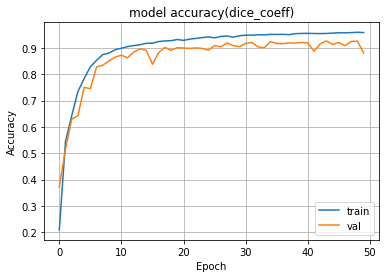

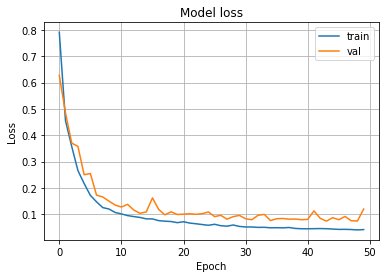

In [33]:
#hist = '/masvol/heartsmart/unet_model/baseline/results/combined_1_3_0_256_dicecoef_learning_history.json'
hist = '/masvol/heartsmart/unet_model/baseline/results/combined_1_3_0_256_drop_dicecoef_learning_history.json'
plot_accuracy_and_loss(hist)

In [ ]:
perf176_df

In [ ]:
perf176_df

In [ ]:
for results_file in explist256 :
    history_file = RESULTS_PATH + results_file + '_learning_history.json'
    print ('='*30)
    print ('='*30)
    print ("Learning history of :" + results_file)
    print ('-'*30)
    
    plot_accuracy_and_loss(history_file)
    

In [ ]:
for results_file in explist176 :
    history_file = RESULTS_PATH + results_file + '_learning_history.json'
    print ('='*30)
    print ('='*30)
    print ("Learning history of :" + results_file)
    print ('-'*30)
    
    plot_accuracy_and_loss(history_file)

In [ ]:
# label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
# pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_predictions.npy"
# y_true_f = np.load(label_file)
# y_pred_f = np.load(pred_file)
# p = get_performance_statistics(y_true_f, y_pred_f)
# print (p)

In [ ]:
# perf_file = "perf_values.json"
# print ("Saving Performance values", perf_file)
# with open(perf_file, 'w') as file:
#     json.dump(p, file, indent=2)
# print('-'*30)

## Analysis on training with 256x256  combined data set (ACDC + Sunnybrook)
### Below are the results of 4 tests
1. Training with combined dataset
2. Training with combined dataset + Augmentation
3. Training with combined dataset (no augmentation),  using Unet with dropout layers
4. Training with combined dataset + Augmentation,  using Unet with dropout layers

Number of Samples : 270, image size : 256 x 256 
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours [38, 53, 70, 87, 145, 151]
Sample Index of predictions with zero contours [50, 72, 116, 188]
max-sigmoid values with zero contours [0.00059099623, 0.0059099565, 0.030844977, 0.0041914172]
(270,)
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 0 []
Sample Index where missed predictions >25% 73 [2, 3, 5, 10, 13, 18, 21, 23, 30, 32, 37, 38, 42, 50, 53, 55, 63, 70, 72, 73, 83, 86, 87, 113, 116, 117, 118, 126, 129, 131, 134, 135, 143, 145, 151, 152, 154, 161, 162, 164, 174, 176, 177, 182, 184, 185, 188, 191, 194, 201, 202, 203, 207, 211, 212, 214, 218, 222, 224, 226, 227, 228, 229, 230, 231, 239, 240, 241, 245, 248, 258, 267, 269]
Sample Index where missed predictions >50% 44 [2, 5, 10, 13, 18, 30, 37, 38, 42,

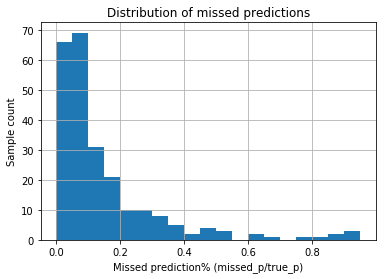

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


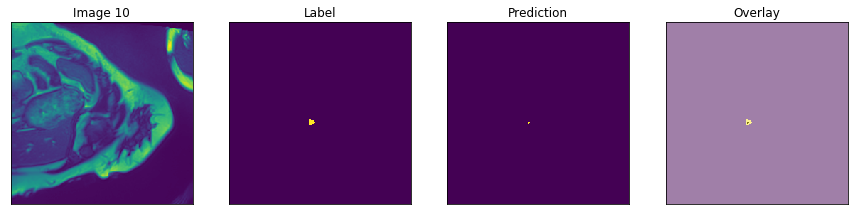

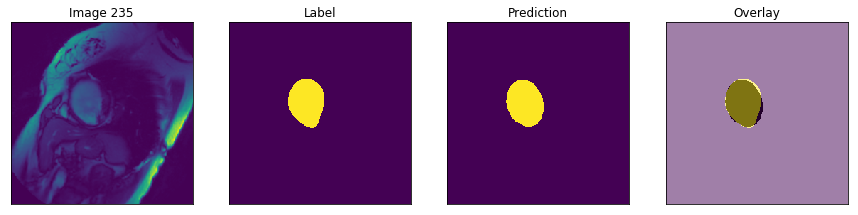

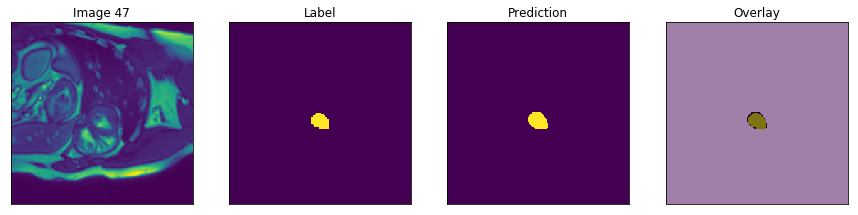

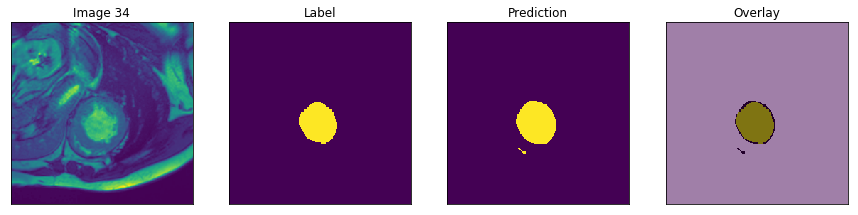

------------------------------
------------------------------
samples, max, min  270 1.0 0.0


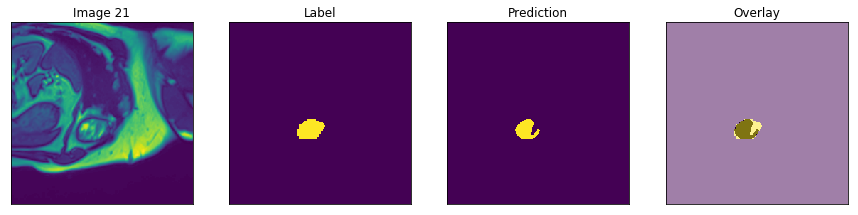

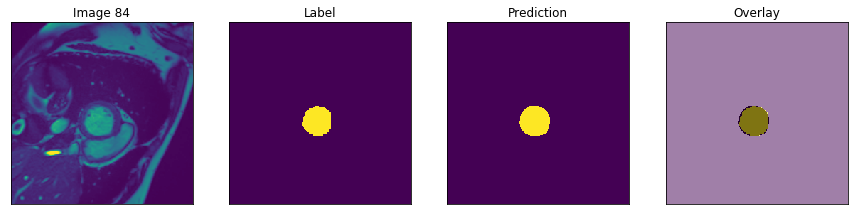

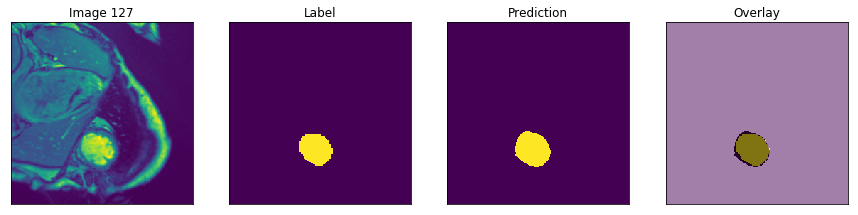

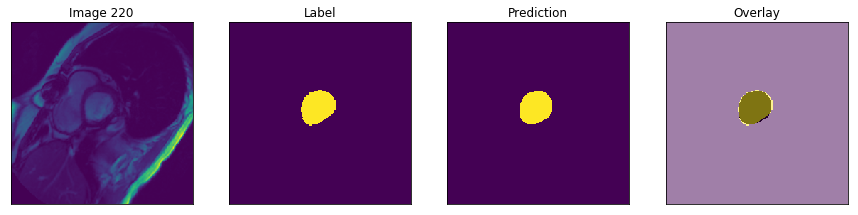

In [42]:
history_file = '/masvol/heartsmart/unet_model/baseline/results/combined_1_3_0_256_drop_dicecoef_learning_history.json'
image_file = "/masvol/heartsmart/unet_model/baseline/data/combined_1_3_0_256_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/baseline/data/combined_1_3_0_256_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/baseline/results/combined_1_3_0_256_drop_dicecoef_predictions.npy"
#plot_accuracy_and_loss(history_file)
#perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [21, 84, 127, 220]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)


samples, max, min  270 1.0 0.0


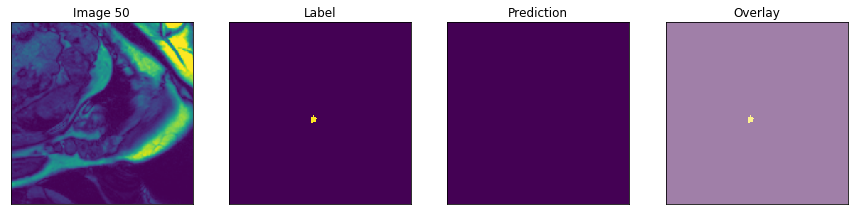

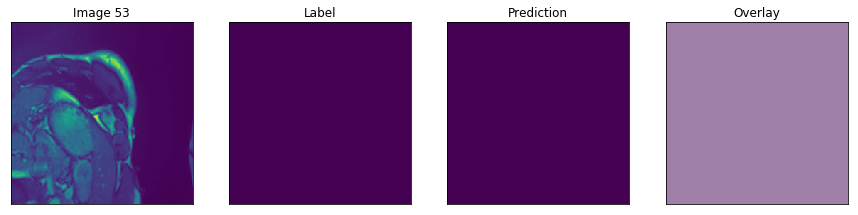

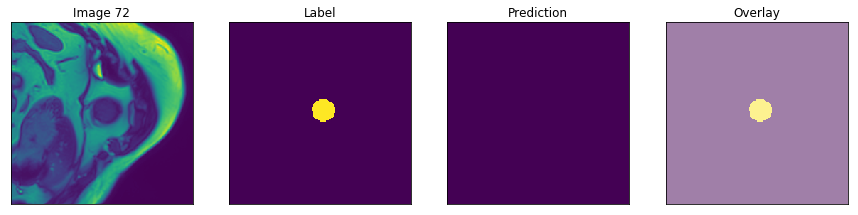

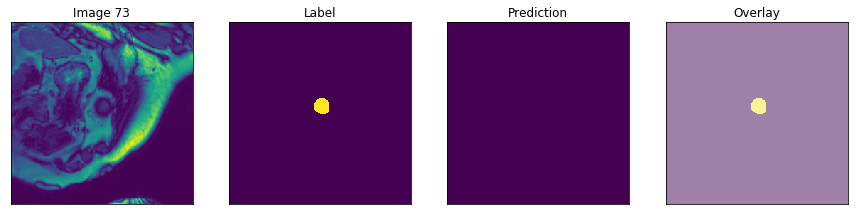

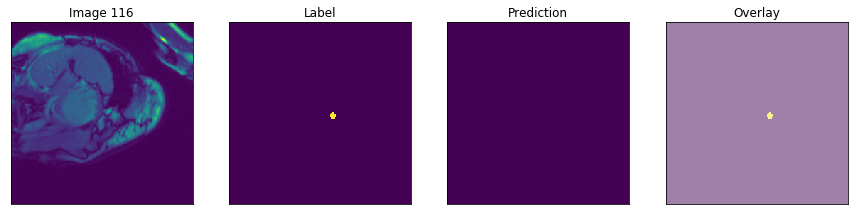

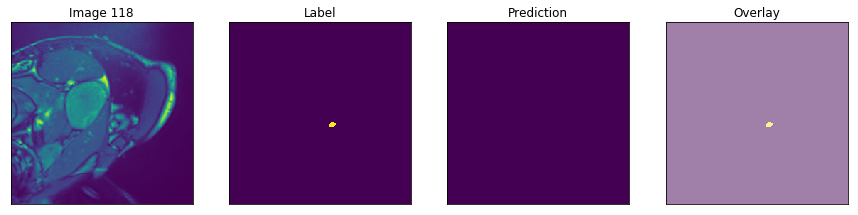

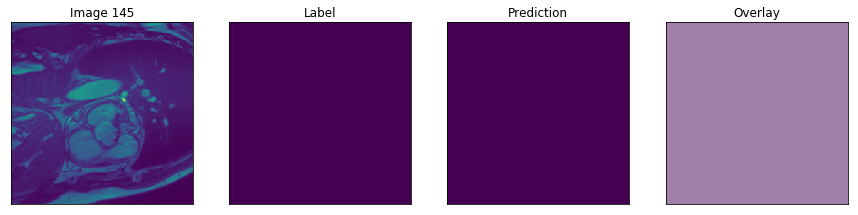

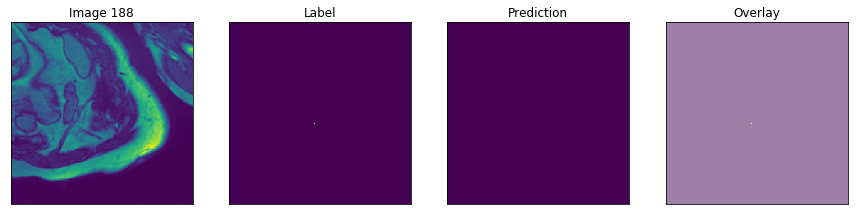

In [32]:
zcontour = [50, 53, 72, 73, 116, 118, 145, 188]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [21, 84, 127, 220]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)


Number of Samples : 260, image size : 256 x 256 
------------------------------
Outliers
------------------------------
Sample Index of labels with zero contours []
Sample Index of predictions with zero contours [21, 22]
max-sigmoid values with zero contours [0.0022999034, 0.40146476]
(260,)
------------------------------
Statistics on missed predictions of contour pixels (white pixels)
------------------------------
Sample Index where missed predictions <.05% 4 [42, 119, 123, 184]
Sample Index where missed predictions >25% 21 [11, 16, 19, 21, 22, 31, 35, 68, 76, 84, 127, 157, 165, 192, 193, 217, 218, 220, 229, 256, 259]
Sample Index where missed predictions >50% 11 [11, 16, 21, 22, 35, 127, 157, 192, 193, 218, 220]
Sample Index where missed predictions >= 100% 4 [11, 21, 22, 218]


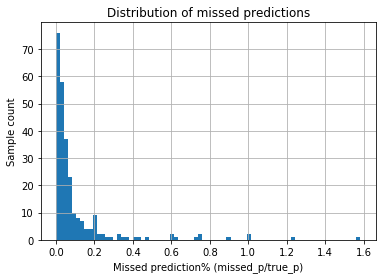

------------------------------
------------------------------
samples, max, min  260 1.0 0.0


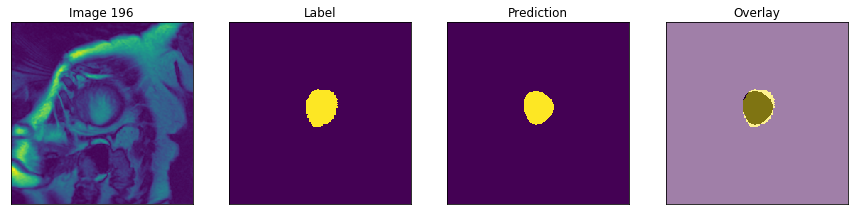

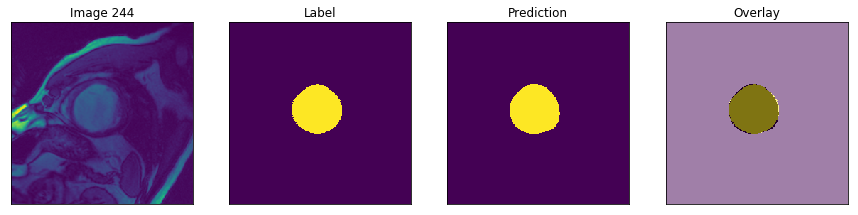

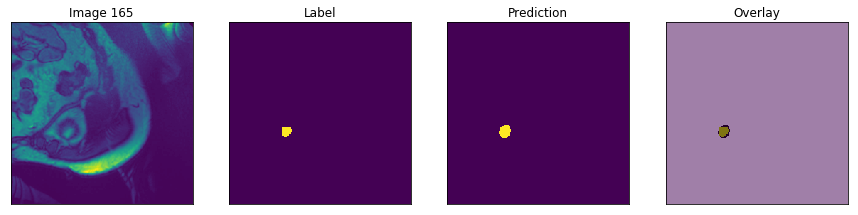

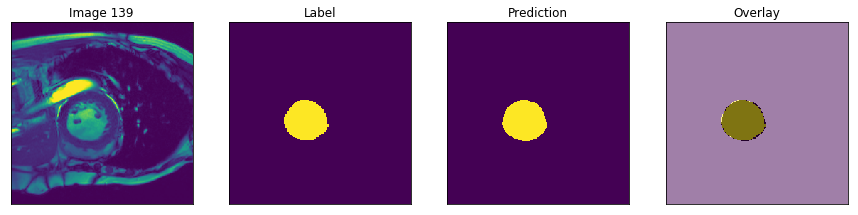

------------------------------
------------------------------
samples, max, min  260 1.0 0.0


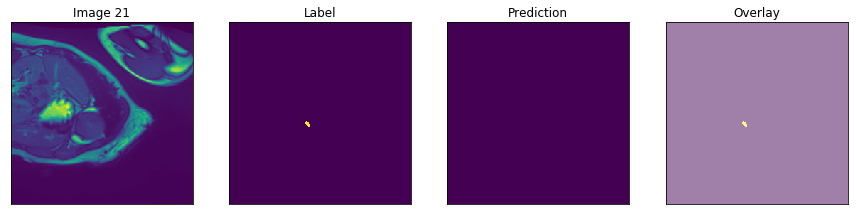

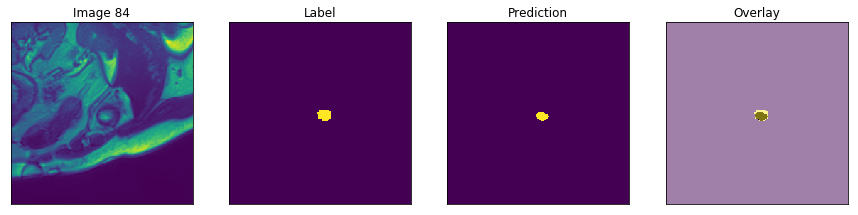

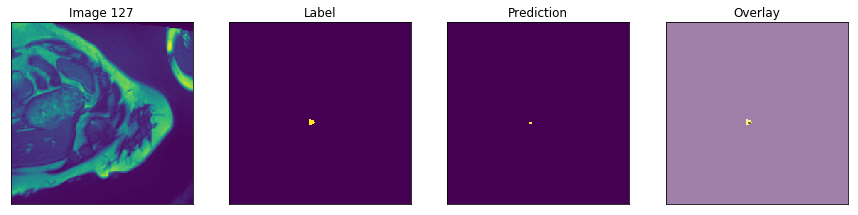

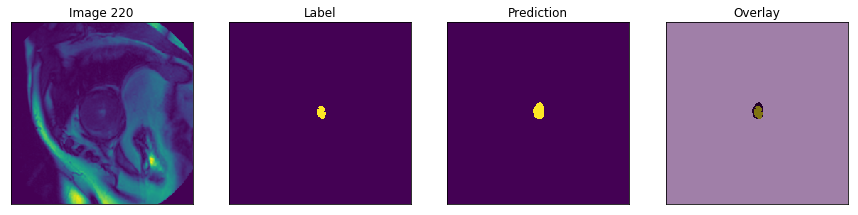

In [24]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_1_3_256_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_1_3_256_predictions.npy"
#plot_accuracy_and_loss(history_file)
#perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [21, 84, 127, 220]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_256_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_256_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [11, 127, 165, 184, 192, 204, 217, 229]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_256_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_256_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [11, 21, 22, 127, 192, 204, 217, 220]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

## Analysis on training with 176x176  combined data set (ACDC + Sunnybrook)
### Below are the results of 4 tests
1. Training with combined dataset
2. Training with combined dataset + Augmentation
3. Training with combined dataset (no augmentation),  using Unet with dropout layers
4. Training with combined dataset + Augmentation,  using Unet with dropout layers

In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [47, 68, 81, 82, 141, 155, 173, 202, 213]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)


In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_1_3_176_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_1_3_176_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [68, 130, 141, 173, 188, 191, 226]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_176_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_drop_1_3_176_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [47, 68, 81, 82, 141, 155, 173, 202, 213]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
zcontour = [0, 19, 47, 55, 68, 81 ]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
#Best predictions:
bestp = [27, 112, 123]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = bestp)

In [ ]:
history_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_176_learning_history.json"
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
label_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_labels.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_aug_drop_1_3_176_predictions.npy"
plot_accuracy_and_loss(history_file)
perf = compute_performance_statistics(label_file, pred_file)
find_outliers(label_file, pred_file)
display_images_labels_predictions (image_file, label_file, pred_file, num_images = 4, random_images = True)
print('-'*30)
print('-'*30)
zcontour = [47, 68, 81, 82, 141, 155, 173, 202, 213]
display_images_labels_predictions (image_file, label_file, pred_file, image_list = zcontour)

In [ ]:
## 

## Analysis of predictions on  DSB data set (256x256  images)

In [ ]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_test_images.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_256_predictions.npy"
find_outliers_in_prediction(pred_file)
display_images_predictions (image_file, pred_file, num_images = 4, random_images = True)
print ("-"*30)
imglist = [21, 84, 127]
display_images_predictions (image_file, pred_file, image_list = imglist)


## Analysis of predictions on  DSB data set (176x176  images)

In [ ]:
image_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_test_images.npy"
pred_file = "/masvol/heartsmart/unet_model/data/baseline/combined_1_3_176_predictions.npy"
find_outliers_in_prediction(pred_file)
display_images_predictions (image_file, pred_file, num_images = 4, random_images = True)
print ("-"*30)
print ("-"*30)
imglist = [173]
display_images_predictions (image_file, pred_file, image_list = imglist)